In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
%matplotlib inline

# 1. 数据集

## 1.1 载入与浏览

In [2]:
# 将数据从PIL类型转换为32位float
# 除 255 使得所有的 数值都在 0-1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST("./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST("./data", train=False, transform=trans, download=True)

26422272it [00:03, 8452325.12it/s]                                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



29696it [00:00, 209374.30it/s]                                                  


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



4422656it [00:04, 994465.44it/s]                                                


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



6144it [00:00, 4711977.29it/s]                                                  

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!



/opt/homebrew/Caskroom/miniforge/base/envs/Atari/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804326539/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [16]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [17]:
import matplotlib.pyplot as plt

In [56]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2.0):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            # PIL
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
            
    return axes

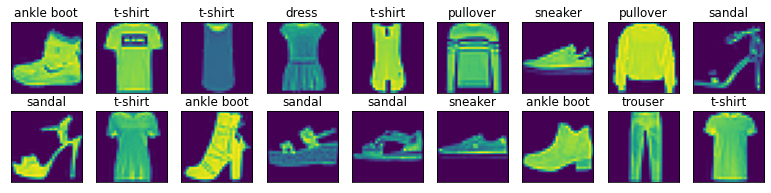

In [30]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28), 2, 9, titles=get_fashion_mnist_labels(y));

## 1.2 按批量读取

In [43]:
batch_size = 256

def get_dataloader_workers():
    return 8

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

In [44]:
%%time
for X, y in train_iter:
    continue

CPU times: user 271 ms, sys: 235 ms, total: 505 ms
Wall time: 1.29 s


## 1.3 整合在一起

In [52]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    # 如果有resize，先做resize，然后再转换到tensor
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='./data/', train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST("./data", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()), 
           data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))
    

In [53]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)

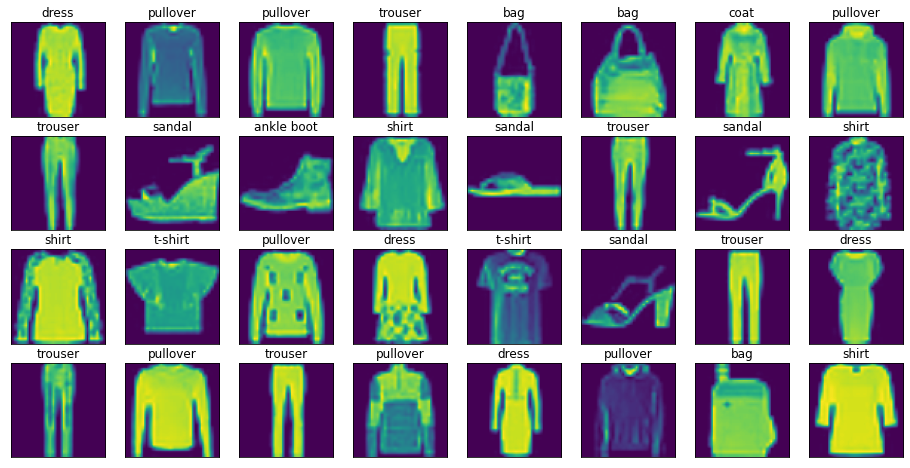

In [57]:
X, y = next(iter(train_iter))
show_images(X.reshape(32,64,64), 4, 8, titles=get_fashion_mnist_labels(y));

In [55]:
X.shape

torch.Size([32, 1, 64, 64])

# 2. softmax 从零开始

In [59]:
import torch
from IPython import display

In [60]:
train_iter, test_iter = load_data_fashion_mnist(256)

In [157]:
num_inputs = 28*28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 2.1 定义softmax操作

In [64]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp/partition

In [65]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.2915, 0.2132, 0.3726, 0.0864, 0.0363],
         [0.0705, 0.1029, 0.2219, 0.4585, 0.1463]]),
 tensor([1.0000, 1.0000]))

## 2.2 定义model、loss

In [67]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, len(W)), W) + b)

关于cross entropy loss 的使用，通常配合softmax一起来。本质是用来很亮两个离散概率分布的相似度。源于entropy的定义。

-p(Y)log(q(Y)), p是标签，q是预测值。

其中p是onehot编码，只有真正true的label对应的概率为1，其余都是零，所以p向量和logq向量做乘法，仅仅会保留p中为1的那一项，其余的都为0

也就是说真正的loss 只有 -log(q(yi)), yi中的i 为p中Y为1时对应的下标


In [179]:
def loss(y_hat, y):
    # 从每一行中挑选出对应的index == y
    # 1 * n
    return -torch.log(y_hat[range(len(y_hat)), y])

## 2.3 分类精度

In [114]:
def accurancy(y, y_hat):
    if len(y_hat) > 1 and len(y_hat[0]) > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat == y
    return cmp.sum().item()

In [108]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
        
    # 在原本的基础上进行累加操作
    def add(self, *args):
        self.data = [a + b for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [116]:
def evaluate_accurancy(net, data_iter):
    
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accurancy(y, net(X)), len(y))
                   
    return metric[0]/metric[1]
    

In [118]:
evaluate_accurancy(net, test_iter)

0.0388

## 2.4 训练

In [180]:
# 需要网络，数据，loss function, 优化器
def train_softmax_model_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    # cum loss, cum accurancy, cum total num
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        L = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            L.mean().backward()
            updater.step()
        else:
            L.sum().backward() # 已经将梯度做了回传
            updater(X.shape[0]) # 这里就是 SGD 的实现
            
        metric.add(L.sum().detach().numpy(), accurancy(y, y_hat), y.numel())
        
    # 返回训练损失 和 训练精度
    return metric[0]/metric[2], metric[1]/metric[2]
        

这里实现一个画动图的class，为后续铺垫

In [162]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: 
        axes.legend(legend)
    axes.grid()

In [164]:
class Animator:
    
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None,  xscale='linear', yscale='linear',
                fmts=('-','m--','g-.','r:'), nrows=1,ncols=1,figsize=(3.5,2.5)):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        # print(self.X,'\n', self.Y)
        self.axes[0].cla()
        
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
            print(x, y)
        self.config_axes()
        
        display.display(self.fig)
        display.clear_output(wait=True)

In [175]:
def train_softmax_model(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                       legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metric = train_softmax_model_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accurancy(net, test_iter)
        animator.add(epoch+1, train_metric + (test_acc,))
    
    train_loss, train_acc = train_metric
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [152]:
lr = 0.1
def updater(batch_size):
    # 关掉 计算梯度
    with torch.no_grad():
        for param in [W, b]:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

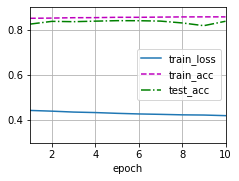

In [165]:
num_epochs = 10
train_softmax_model(net, train_iter, test_iter, loss, num_epochs, updater)

## 2.5 预测

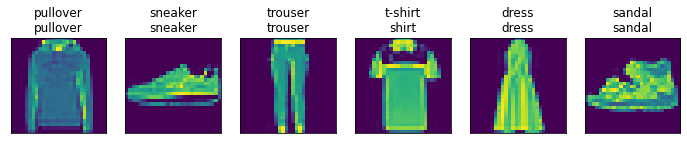

In [168]:
def predict_softmax(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles)
    
    
predict_softmax(net, test_iter)

# 3. softmax 简洁实现

In [169]:
from torch import nn

# flatten 把image拍平了
net = nn.Sequential(
    nn.Flatten(), nn.Linear(num_inputs, num_outputs))

# 只有当m为Linear层的时候，才会需要初始化参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [176]:
loss = nn.CrossEntropyLoss(reduction='None')

In [177]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

AssertionError: nan

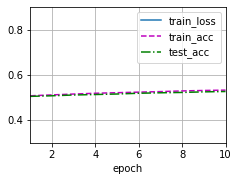

In [183]:
num_epochs = 10

train_softmax_model(net, train_iter, test_iter, loss, num_epochs, trainer)